# Exercise 1

**Task:** *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import notebook

RANDOM_SEED = 42

%matplotlib inline
sns.set_theme()

In [2]:
# Reading the text file with names into a variable
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
print(f"Number of names: {len(words):,}")

Number of names: 32,033


In [4]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

In [5]:
char2id

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
id2char

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Bigram model

Firstly, we will replicate the bigram model from the video. Let's create the dataset:

In [7]:
X_bigram, Y_bigram = [], []

for word in words:
    # Adding special token for each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2 in zip(chars, chars[1:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        
        # Adding letter indices to lists
        X_bigram.append(index_1)
        Y_bigram.append(index_2)

# Casting as PyTorch tensors
X_bigram = torch.tensor(X_bigram)
Y_bigram = torch.tensor(Y_bigram)

In [8]:
print(X_bigram) 
print(Y_bigram)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


It can be seen that we have managed to create a dataset where we predict the next letter given the previous one. 

Now, we will include all the code for training the bigram model inside the `BigramModel` class.

In [9]:
class BigramModel:
    def __init__(
        self, 
        num_features, 
        num_outputs, 
        num_epochs, 
        learning_rate,
        logging=False,
        regularize=False, 
        smooth_strength=None, 
        seed=2147483647,
        enable_tqdm=True,
        *args,
        **kwargs,
    ):
        """Initializes BigramModel instance."""
        # Creating class attributes
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.logging = logging
        self.regularize = regularize
        self.smooth_strength = smooth_strength
        self.seed = seed
        self.enable_tqdm = enable_tqdm
        # Generating random weights based on a random seed
        generator = torch.Generator().manual_seed(self.seed)
        self.weights = torch.randn((self.num_features, self.num_outputs), generator=generator)
        self.weights.requires_grad = True
        
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        # One-hot encoding NN inputs
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float()
        # Computing predictions for log-counts
        logits = x_encoded @ self.weights
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def fit(self, x, y):
        """Fits the NN to data."""
        # Preallocating a dict for storing loss across epochs
        loss_per_epoch = {}
        # Utilizing a progress bar when training or not
        epoch_counter = notebook.tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)
        for k in epoch_counter:
            # Making a forward pass and computing a loss
            loss = self(x, y)
            # Adding a loss computed to the history
            loss_per_epoch[f"epoch_{k+1}"] = loss.item()
            # Logging progress
            if self.logging:
                print(f"Epoch {k + 1:03d}/{self.num_epochs:03d}: loss = {loss.item():.4f}")
            
            # Setting gradients to zero
            self.weights.grad = None
            # Making a backward pass (initiating backpropagation)
            loss.backward()
            
            # Updating weights (SGD)
            self.weights.data -= self.learning_rate * self.weights.grad
        
        # Creating an attribute for training history after training
        self.history = loss_per_epoch
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        # Preallocating a list for storing generated names
        generated_names = []
        for i in range(num_examples):
            # Preallocating a list for storing letters
            out = []
            # Starting names generation with "."
            ix = 0
            while True:
                # Computing probabilities for the next character
                x_encoded = F.one_hot(torch.tensor([ix]), num_classes=self.num_outputs).float()
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                # Retrieving a letter index from the probability distribution
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the letter to a list
                out.append(id2char[ix])
                # Iterating until "." is encountered
                if ix == 0:
                    break
            
            # Joining letters together to compose a word and add to other examples
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

We can now use this class to train the model on the data. We have 27 possible one-letter symbols so the number of input and output features will be the same - 27. Model will be trained for 100 epochs with a learning rate of 50 (in order to faster reach local extrema). Additionally, we will apply regularization with a smoothing strength of 0.01.

In [10]:
# Instantiating a bigram model
bigram_model = BigramModel(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
bigram_model.fit(X_bigram, Y_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

Now the information about the training history is stored in `history` attribute. Let's try to generate some new examples based on the new weights:

In [11]:
# Generating 10 new examples
bigram_model.generate_sample(num_examples=10, id2char=id2char)

['mor',
 'axx',
 'minaymoryles',
 'kondmaisah',
 'anchthizarie',
 'odaren',
 'iaddash',
 'h',
 'jionatien',
 'egwver']

It is seen that the names do not really make much sense but nevertheless some of them remind of some words.

## Trigram model

Now we can get to the actual exercise and build the trigram model. Firstly, we need to create a dataset where we will take two characters as input to use this information to predict the third one.

In [12]:
X_trigram, Y_trigram = [], []
for word in words:
    # Adding special token for each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2, char_3 in zip(chars, chars[1:], chars[2:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        index_3 = char2id[char_3]
        
        # Adding letter indices to lists
        X_trigram.append([index_1, index_2])
        Y_trigram.append(index_3)

# Casting as PyTorch tensors
X_trigram = torch.tensor(X_trigram)
Y_trigram = torch.tensor(Y_trigram)

In [13]:
print(X_trigram) 
print(Y_trigram)

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])
tensor([13, 13,  1,  ..., 26, 24,  0])


It is seen that for the first training example we take letters with ids $0$ and $5$ and use them to extract information about the next character with id $13$. 

The next step is to build the model. There are some differences in the way we will create the trigram model so in this case we will subclass `BigramModel` and reimplement some methods that will override the methods of the inherited class.

In [14]:
class TrigramModel(BigramModel):
    def __init__(self, *args, **kwargs):
        """Inherits initialization schema from BigramModel class."""
        super().__init__(*args, **kwargs)
    
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float().view(-1, self.num_features)
        logits = x_encoded @ self.weights # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probas = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect.")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        generated_names = []
        for i in range(num_examples):
            out = []
            # Initializing the starting sequence
            context = [0, 0] 
            while True:
                x_encoded = F.one_hot(torch.tensor([context]), num_classes=self.num_outputs).float().view(1, -1)
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the predicted character and shifting
                context = context[1:] + [ix]
                out.append(id2char[ix])
                if ix == 0:
                    break
                    
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

Now we can create the object of the class defined above. One of the differences with the bigram model is that in this case we will specify `num_features=54`, since now we have to use two characters as input so upon one-hot encoding additional dimension for 27 characters will pop up.

In [15]:
# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_trigram, Y_trigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
trigram_model.generate_sample(num_examples=10, id2char=id2char)

['nor',
 'ays',
 'nileyloryear',
 'erellais',
 'ah',
 'neithizarie',
 'ok',
 'ondalaek',
 're',
 'ailindeshan']

When using the trigram model, it is seen that the names become more and more similar to some names.

## Comparison

Now we can compare the performance of the two model by using data about loss history we included in `history` attribute.

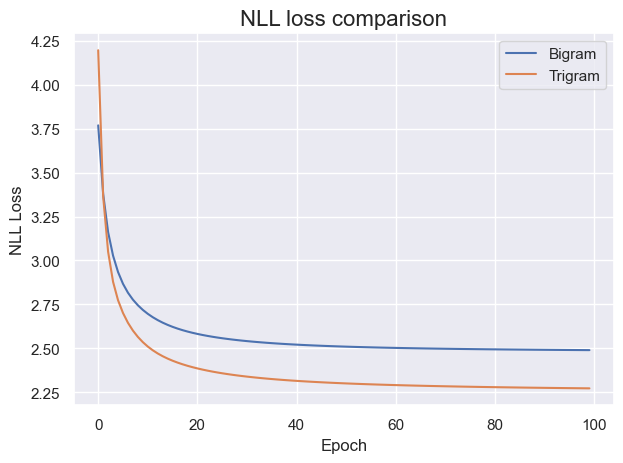

In [17]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison", fontsize=16)
plt.tight_layout()
plt.show()

It can be seen that trigram seems to be performing better than bigram model which has also been seen by a better quality of names generated.

# Exercise 2

**Task:** *Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?*

Firstly, let's select which names will be included in each set. We will reshuffle all names in the list and define the cutoffs which would govern which names will fall under training, dev and test sets.

In [18]:
len(words)

32033

In [19]:
# Setting the random seed and reshuffling names
random.seed(RANDOM_SEED)
random.shuffle(words)

# Determining cutoff points for 10% dev and 10% test
cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032


In [20]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


Next, we will implement `build_dataset` function written below which will create the datasets themselves. It takes our list of names (already split into three parts) and the block size which refers to how many characters we want to use to predict the next one.

In [21]:
def build_dataset(words, block_size):
    """Creates a dataset for n-gram model."""
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # Reshaping if using bigram model
    if block_size == 1:
        X = X.view(-1)
    
    return X, Y

## Bigram model

In [22]:
# Building the datasets for three sets (Bigram model)
X_train_bigram, Y_train_bigram = build_dataset(words=words_train, block_size=1)
X_dev_bigram, Y_dev_bigram = build_dataset(words=words_dev, block_size=1)
X_test_bigram, Y_test_bigram = build_dataset(words=words_test, block_size=1)

In [23]:
bigram_model = BigramModel(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

We have successfully train the bigram model only on the training set. We can now call the object of the class as a function in order to compute losses for each set.

In [24]:
# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

Train loss: 2.4899
Dev loss: 2.4880
Test loss: 2.4943


## Trigram model

In [25]:
X_train_trigram, Y_train_trigram = build_dataset(words=words_train, block_size=2)
X_dev_trigram, Y_dev_trigram = build_dataset(words=words_dev, block_size=2)
X_test_trigram, Y_test_trigram = build_dataset(words=words_test, block_size=2)

In [26]:
# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_train_trigram, Y_train_trigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
trigram_train_loss = trigram_model(X_train_trigram, Y_train_trigram).item()
trigram_dev_loss = trigram_model(X_dev_trigram, Y_dev_trigram).item()
trigram_test_loss = trigram_model(X_test_trigram, Y_test_trigram).item()

print(f"Train loss: {trigram_train_loss:.4f}")
print(f"Dev loss: {trigram_dev_loss:.4f}")
print(f"Test loss: {trigram_test_loss:.4f}")

Train loss: 2.3942
Dev loss: 2.3929
Test loss: 2.3974


## Comparison

In [28]:
# Combining training, dev and test losses for each model
losses = {
    "bigram_loss": [bigram_train_loss, bigram_dev_loss, bigram_test_loss],
    "trigram_loss": [trigram_train_loss, trigram_dev_loss, trigram_test_loss]
}

index = ["train", "dev", "test"]
loss_set_df = pd.DataFrame(losses, index=index).round(4)
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.3942
dev,2.4880,2.3929
test,2.4943,2.3974


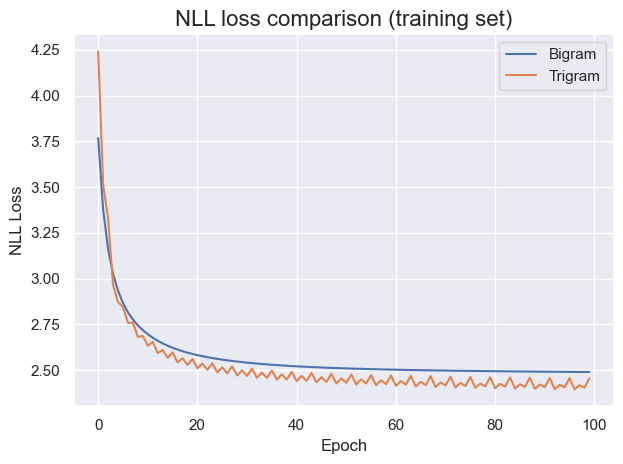

In [29]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison (training set)", fontsize=16)
plt.tight_layout()
plt.show()

It is seen from the comparison plot that training the model only on the training set creates some bumps during the whole training process.

Let's see if the quality of names generation changed somehow.

In [30]:
bigram_model.generate_sample(num_examples=10, id2char=id2char)

['mor',
 'axx',
 'minaymorykas',
 'kondn',
 'isah',
 'anchthizarie',
 'odaren',
 'iaddash',
 'h',
 'jionatien']

In [31]:
trigram_model.generate_sample(num_examples=10, id2char=id2char)

['mir',
 'ays',
 'len',
 'watsyebraisemiabrada',
 'manthizarie',
 'na',
 'nah',
 'gach',
 'sabgellinasideia',
 'ynar']

# Exercise 3

**Task:** *Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?*

In [32]:
# Defining the smoothing rates to be checked
strengths = np.arange(0.00, 0.11, 0.01)
strengths

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [33]:
# Preallocating a variable for best loss selection
best_dev_loss = np.Inf
# Preallocating a variable for storing best regularization rate
best_strength = 0
# Preallocating a variable for storing the best model
best_model = None

# Launching tuning procedure
for strength in strengths:
    # Instantiating a model
    model = TrigramModel(
        num_features=54, 
        num_outputs=27,
        num_epochs=100,
        learning_rate=50, 
        regularize=True, 
        smooth_strength=strength,
        enable_tqdm=False,
    )
    
    # Training
    model.fit(X_train_trigram, Y_train_trigram)
    
    # Computing train/dev loss
    train_loss = model(X_train_trigram, Y_train_trigram).item()
    dev_loss = model(X_dev_trigram, Y_dev_trigram).item()
    
    # Making a decision about the best smoothing strength
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        best_strength = strength
        best_model = model
    
    # Logging the results
    print(f"strength = {strength:.2f}: train_loss = {train_loss:.4f}, dev_loss = {dev_loss:.4f}")
    
print(f"\nBest dev loss: {best_dev_loss:.4f}")
print(f"Best strength: {best_strength:.2f}")

test_loss = best_model(X_test_trigram, Y_test_trigram).item()
print(f"\nTest set loss: {test_loss:.4f}")

strength = 0.00: train_loss = 2.3857, dev_loss = 2.3844
strength = 0.01: train_loss = 2.3942, dev_loss = 2.3929
strength = 0.02: train_loss = 2.4019, dev_loss = 2.4005
strength = 0.03: train_loss = 2.4088, dev_loss = 2.4074
strength = 0.04: train_loss = 2.4152, dev_loss = 2.4138
strength = 0.05: train_loss = 2.4210, dev_loss = 2.4196
strength = 0.06: train_loss = 2.4264, dev_loss = 2.4250
strength = 0.07: train_loss = 2.4315, dev_loss = 2.4301
strength = 0.08: train_loss = 2.4363, dev_loss = 2.4348
strength = 0.09: train_loss = 2.4409, dev_loss = 2.4394
strength = 0.10: train_loss = 2.4452, dev_loss = 2.4437

Best dev loss: 2.3844
Best strength: 0.00

Test set loss: 2.3889


In [34]:
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.3942
dev,2.4880,2.3929
test,2.4943,2.3974


We can see that the best smoothing strength proved to be zero meaning that the best model is the one without any regularization. Besides, it was possible to slightly surpass the previously obtain test loss of $2.3974$.

In [35]:
best_model.generate_sample(num_examples=10, id2char=id2char)

['mhi',
 'ays',
 'len',
 'watsyebraisemiabrada',
 'manthizarie',
 'na',
 'nah',
 'fafeishalekirierielah',
 'ynar',
 'ed']

# Exercise 4

**Task:** *We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

In [36]:
class BigramModelV2(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        # Computing predictions for log-counts (THE ONLY CHANGE)
        logits = self.weights[x]
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss

In [37]:
bigram_model = BigramModelV2(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.4899
Dev loss: 2.4880
Test loss: 2.4943


In [38]:
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.3942
dev,2.4880,2.3929
test,2.4943,2.3974


By simply indexing the rows of the weight matrix, we were able to slightly speed up the computations while achieving the same results as above.

# Exercise 5

**Task:** *Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?*

## Bigram model

In [39]:
class BigramModelV3(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        # Computing predictions for log-counts
        logits = self.weights[x]
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = F.cross_entropy(logits, y) + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = F.cross_entropy(logits, y)
            
        return loss

In [40]:
bigram_model = BigramModelV3(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.4899
Dev loss: 2.4880
Test loss: 2.4943


## Trigram model

In [41]:
class TrigramModelV3(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float().view(-1, self.num_features)
        logits = x_encoded @ self.weights
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = F.cross_entropy(logits, y) + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = F.cross_entropy(logits, y)
            
        return loss

In [42]:
trigram_model = TrigramModelV3(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

trigram_model.fit(X_train_trigram, Y_train_trigram)

# Computing losses for the three sets
trigram_train_loss = trigram_model(X_train_trigram, Y_train_trigram).item()
trigram_dev_loss = trigram_model(X_dev_trigram, Y_dev_trigram).item()
trigram_test_loss = trigram_model(X_test_trigram, Y_test_trigram).item()

print(f"Train loss: {trigram_train_loss:.4f}")
print(f"Dev loss: {trigram_dev_loss:.4f}")
print(f"Test loss: {trigram_test_loss:.4f}\n")

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.3942
Dev loss: 2.3929
Test loss: 2.3974



It is seen that we were able to achieve the same results as before. In this case we have made use of `cross_entropy` function which represents a more optimized function from `torch` library that is able to speed up the computations even more.